### Building a Robust Algorithm Harness for Binary Classification: A Step-by-Step Guide Spotify api

https://drlee.io/building-a-robust-algorithm-harness-for-binary-classification-a-step-by-step-guide-29592c64fe46

### Use Case: Predicting Target Songs on Spotify
Our use case involves predicting whether a song meets a specific target condition based on its features. The target can represent a variety of outcomes: for example, predicting whether a song will become popular, whether it fits into a particular playlist, or even whether it matches a user’s preferences. The goal is to classify songs into two categories — target group (1) or non-target group (0) — based on a range of musical and acoustic attributes provided in the Spotify dataset. In this case — 1 means that the song is liked and 0 means that it is not liked.

By training various machine learning models on these song attributes, we can identify which models best predict the target outcome.

Data
We’ll be using a dataset from Spotify, which contains detailed information about songs, including the following features:

acousticness: Confidence measure of whether the track is acoustic.
danceability: How suitable the track is for dancing.
duration_ms: The duration of the track in milliseconds.
energy: The intensity and activity level of the track.
instrumentalness: Predicts whether a track has no vocals.
key: The musical key the track is in.
liveness: Detects the presence of an audience.
loudness: The overall loudness of the track.
mode: The mode of the track (major or minor).
speechiness: Measures spoken words in a track.
tempo: The beats per minute (BPM) of the track.
time_signature: The number of beats in a bar.
valence: A measure of how positive or happy the track sounds.
target: A binary indicator (1 for target, 0 for non-target), which is the variable we will be predicting.
song_title: The name of the song.
artist: The name of the artist.

In [2]:
### Step 1: Install and Import the Necessary Libraries
# Install additional libraries (if necessary)
!pip install xgboost lightgbm catboost -qqq

In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import (LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, 
                              HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
# Step 2: Load the Dataset
# Load the Spotify dataset
url = 'https://github.com/fenago/datasets/raw/refs/heads/main/spotify.csv'
df = pd.read_csv(url)

# Preview the dataset
df.sample(5)

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
164,164,0.0682,0.557,293910,0.608,0.026300,5,0.1960,-7.657,0,0.0862,109.670,4,0.211,1,Papi Pacify,FKA twigs
805,805,0.4640,0.535,178867,0.910,0.000093,10,0.0745,-4.827,1,0.0328,111.027,4,0.956,1,Be Brave,The Strange Boys
747,747,0.1340,0.359,229147,0.662,0.000000,1,0.0907,-2.843,1,0.0466,152.096,4,0.296,1,Bound 2,Kanye West
516,516,0.5200,0.582,212602,0.903,0.779000,0,0.2430,-4.505,1,0.0335,119.457,4,0.902,1,Chicken Half,Sugarman Three
475,475,0.0229,0.527,188560,0.871,0.155000,4,0.4190,-8.708,1,0.0354,120.722,4,0.120,1,I Wanna Be Your Dog,The Stooges


In [5]:
def analyze_columns_for_encoding(df, threshold=50):
    """
    Analyzes the dataframe columns, checking the number of unique values
    and recommending which columns should be dropped, kept, or treated
    before using get_dummies for encoding to avoid dimensionality issues.
    
    Parameters:
    df : pandas.DataFrame
        The dataframe to analyze.
    threshold : int
        The maximum number of unique values in a column to recommend encoding.
    
    Returns:
    report : pandas.DataFrame
        A report with recommendations for each column.
    """
    # Create an empty DataFrame for the report
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Values', 'Recommendation'])
    
    for column in df.columns:
        unique_values = df[column].nunique()
        data_type = df[column].dtype
        
        # Determine the recommendation based on unique values and data type
        if data_type == 'object' or data_type == 'category':
            if unique_values > threshold:
                recommendation = "Consider Dropping or Encoding Differently (Too many categories)"
            elif unique_values == 2:
                recommendation = "Keep (Binary category)"
            else:
                recommendation = "Keep but beware of dimensionality (Low unique categories)"
        elif data_type in ['int64', 'float64']:
            if unique_values == 2:
                recommendation = "Keep (Binary numeric)"
            else:
                recommendation = "Keep (Continuous)"
        else:
            recommendation = "Consider Dropping (Unknown data type)"
        
        # Create a new row with the column analysis
        new_row = pd.DataFrame({
            'Column': [column],
            'Data Type': [data_type],
            'Unique Values': [unique_values],
            'Recommendation': [recommendation]
        })
        
        # Concatenate the new row to the report DataFrame
        report = pd.concat([report, new_row], ignore_index=True)
    
    return report

# Set your threshold for handling categorical variables
threshold_value = 50

# Analyze the dataframe columns
report = analyze_columns_for_encoding(df, threshold=threshold_value)

# Display the report
print(report)

              Column Data Type Unique Values  \
0         Unnamed: 0     int64          2017   
1       acousticness   float64          1394   
2       danceability   float64           632   
3        duration_ms     int64          1921   
4             energy   float64           719   
5   instrumentalness   float64          1107   
6                key     int64            12   
7           liveness   float64           793   
8           loudness   float64          1808   
9               mode     int64             2   
10       speechiness   float64           792   
11             tempo   float64          1919   
12    time_signature     int64             4   
13           valence   float64           853   
14            target     int64             2   
15        song_title    object          1956   
16            artist    object          1343   

                                       Recommendation  
0                                   Keep (Continuous)  
1                      

In [6]:
# Step 3: Data Cleaning and Preprocessing
# Identify the target column
# Identify the target column ... based on the data that you have... what EXACTLY are you trying to predict... which column?  That is your target!  
# Remember that we are scoping this to binary classification - so that column should only have TWO unique values
# I recommend that you RENAME your target column to be named target! --- In this case - the target is actually named target so i don't need to rename

# df = df.rename(columns={'orig_name': 'target'})
# df.head()
# Identify the target column and ensure it's binary (0/1)
# If the column already contains two unique values, we map them to 0 and 1 if necessary

# Get unique values of the target column
unique_values = df['target'].unique()

# Check if the column has exactly two unique values
if len(unique_values) != 2:
    raise ValueError("Target column does not have exactly two unique values for binary classification.")
else:
    # If values are not already 0 and 1, map them to 0 and 1
    if set(unique_values) != {0, 1}:
        value_map = {unique_values[0]: 0, unique_values[1]: 1}
        df['target'] = df['target'].map(value_map)
        print(f"Target values have been mapped to 0 and 1: {value_map}")
    else:
        print("Target values are already in binary (0 and 1).")

# Display the target column and verify the changes
print(f"Target column: {df['target'].name}")
print(df['target'].unique())

Target values are already in binary (0 and 1).
Target column: target
[1 0]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   int64  
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


In [8]:
# Convert data types if necessary (Example) --- clearly you have to think at this point and use YOUR columns for YOUR dataset!
df['duration_ms'] = pd.to_numeric(df['duration_ms'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2017 non-null   int64  
 1   acousticness      2017 non-null   float64
 2   danceability      2017 non-null   float64
 3   duration_ms       2017 non-null   int64  
 4   energy            2017 non-null   float64
 5   instrumentalness  2017 non-null   float64
 6   key               2017 non-null   int64  
 7   liveness          2017 non-null   float64
 8   loudness          2017 non-null   float64
 9   mode              2017 non-null   int64  
 10  speechiness       2017 non-null   float64
 11  tempo             2017 non-null   float64
 12  time_signature    2017 non-null   int64  
 13  valence           2017 non-null   float64
 14  target            2017 non-null   int64  
 15  song_title        2017 non-null   object 
 16  artist            2017 non-null   object 


In [9]:
import pandas as pd

def analyze_object_columns_for_ohe(df, threshold=50):
    """
    Analyzes all object-type columns in the dataframe, computes how many columns 
    would be created using get_dummies (one-hot encoding), and makes a recommendation 
    about whether to keep, drop, or encode the column differently.
    
    Parameters:
    df : pandas.DataFrame
        The dataframe to analyze.
    threshold : int
        The maximum number of unique values in a column to recommend encoding.
    
    Returns:
    report : pandas.DataFrame
        A report with recommendations for each object-type column.
    """
    report = pd.DataFrame(columns=['Column', 'Unique Values', 'Potential OHE Columns', 'Recommendation'])
    
    # Select only object-type columns
    object_cols = df.select_dtypes(include=['object']).columns
    
    for column in object_cols:
        unique_values = df[column].nunique()
        potential_ohe_columns = unique_values  # Number of columns created by get_dummies()
        
        # Make recommendations based on the number of unique values
        if unique_values > threshold:
            recommendation = "Consider Dropping or Encoding Differently (Too many categories)"
        elif unique_values == 2:
            recommendation = "Keep (Binary category)"
        else:
            recommendation = "Keep but beware of dimensionality"
        
        # Create a new row with the column analysis
        new_row = pd.DataFrame({
            'Column': [column],
            'Unique Values': [unique_values],
            'Potential OHE Columns': [potential_ohe_columns],
            'Recommendation': [recommendation]
        })
        
        # Concatenate the new row to the report DataFrame
        report = pd.concat([report, new_row], ignore_index=True)
    
    return report

# Set the threshold for handling categorical variables
threshold_value = 50

# Analyze the dataframe columns that are of type object
report = analyze_object_columns_for_ohe(df, threshold=threshold_value)

# Display the report
print(report)

       Column Unique Values Potential OHE Columns  \
0  song_title          1956                  1956   
1      artist          1343                  1343   

                                      Recommendation  
0  Consider Dropping or Encoding Differently (Too...  
1  Consider Dropping or Encoding Differently (Too...  


In [10]:
# Check the number of unique values per column
print(df.nunique())

# Remove duplicate rows
df = df.drop_duplicates()   # this may need to be a bit more complex based on your use case / data

Unnamed: 0          2017
acousticness        1394
danceability         632
duration_ms         1921
energy               719
instrumentalness    1107
key                   12
liveness             793
loudness            1808
mode                   2
speechiness          792
tempo               1919
time_signature         4
valence              853
target                 2
song_title          1956
artist              1343
dtype: int64


In [11]:
# Check if the target class is balanced
print(df['target'].value_counts())

target
1    1020
0     997
Name: count, dtype: int64


In [12]:
# Drop non-numeric columns that do not contribute to prediction
# df = df.drop(columns=['col1','col2'])
df = df.drop(columns=['Unnamed: 0', 'song_title'])
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   int64  
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  artist            2017 non-null   object 
dtypes: float64(9), int64(5), object(1)
memory usage: 236.5+ KB


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [13]:
# Handle Missing Data
# Check for missing values
print("Rows/Cols before: " + str(df.shape))
print(df.isnull().sum())

# Drop rows with missing values
df = df.dropna()  # Obviously - you have to count the number before and after
print("Rows/Cols after: " + str(df.shape))

Rows/Cols before: (2017, 15)
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
target              0
artist              0
dtype: int64
Rows/Cols after: (2017, 15)


In [14]:
# Check for outliers --- this is optional and I would not do this the first time!
# But I wanted you to have this code in case you need it.  

# from scipy import stats
# print("Rows/Cols before: " + str(df.shape))
# # Remove outliers using Z-score
# z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))
# abs_z_scores = abs(z_scores)
# df = df[(abs_z_scores < 3).all(axis=1)]
# print("Rows/Cols after: " + str(df.shape))8. Scale the Data

In [15]:
# look at the shape before
df.shape
# One-hot encode categorical features (obviously put in all of your cat (object) columns
# This is how you do one col at time
# df = pd.get_dummies(df, columns=['artist'])

# This is how you do all text cols at once:
df = pd.get_dummies(df)

# look at the shape after and see how many columns were created
df.shape

(2017, 1357)

In [16]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['target']))
X = pd.DataFrame(scaled_features, columns=df.drop(columns=['target']).columns)
y = df['target']

In [17]:
# RUN THIS CODE IF YOU DID NOT SCALE YOUR DATA

# Separate the features (X) and the target (y)  --- this was done above
X = df.drop(columns=['target'])  # Features: all columns except the target
y = df['target']                 # Target: the column we're trying to predict

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Define base classifiers for Voting and Stacking
base_classifiers = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))  # Probability required for AUC-ROC
]

In [20]:
# Combine all classifiers, comment out those you don't want to use
classifiers = [
    LogisticRegression(), RidgeClassifier(), SGDClassifier(), Perceptron(),
    SVC(probability=True), KNeighborsClassifier(), RadiusNeighborsClassifier(),
    GaussianProcessClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
    GradientBoostingClassifier(), AdaBoostClassifier(), HistGradientBoostingClassifier(),
    BaggingClassifier(), 
    VotingClassifier(estimators=base_classifiers, voting='soft'),  # Voting Classifier with base classifiers
    StackingClassifier(estimators=base_classifiers),  # Stacking Classifier with base classifiers
    MLPClassifier(),
    GaussianNB(),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), lgb.LGBMClassifier(), CatBoostClassifier(verbose=0)
]

C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()
	Training time: 1.302s
	Prediction time: 0.084s
	Accuracy: 0.574
	Precision: 0.571
	Recall: 0.530
	F1 Score: 0.550
	ROC-AUC Score: 0.597

Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60       206
           1       0.57      0.53      0.55       198

    accuracy                           0.57       404
   macro avg       0.57      0.57      0.57       404
weighted avg       0.57      0.57      0.57       404



C:\Users\sudwa\AppData\Local\Temp\ipykernel_6960\1991987917.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, row], ignore_index=True)


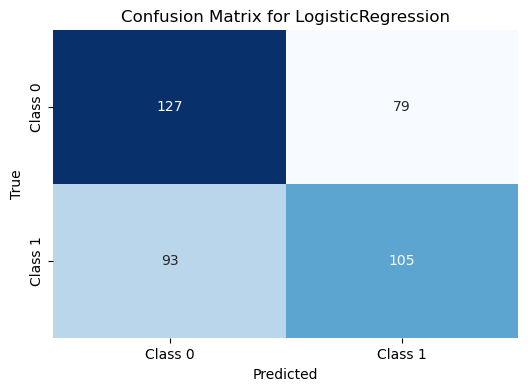

RidgeClassifier()
	Training time: 1.735s
	Prediction time: 0.020s
	Accuracy: 0.780
	Precision: 0.777
	Recall: 0.773
	F1 Score: 0.775

Classification Report for RidgeClassifier:

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       206
           1       0.78      0.77      0.77       198

    accuracy                           0.78       404
   macro avg       0.78      0.78      0.78       404
weighted avg       0.78      0.78      0.78       404



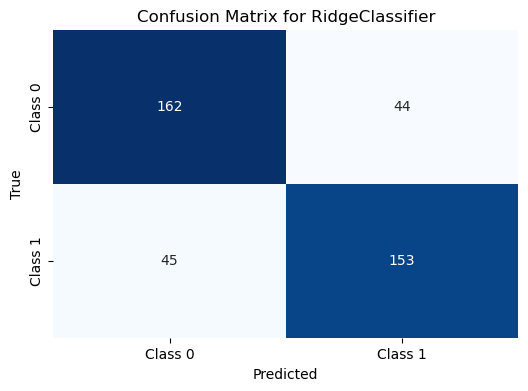

SGDClassifier()
	Training time: 0.802s
	Prediction time: 0.022s
	Accuracy: 0.490
	Precision: 0.490
	Recall: 1.000
	F1 Score: 0.658

Classification Report for SGDClassifier:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       206
           1       0.49      1.00      0.66       198

    accuracy                           0.49       404
   macro avg       0.25      0.50      0.33       404
weighted avg       0.24      0.49      0.32       404



C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


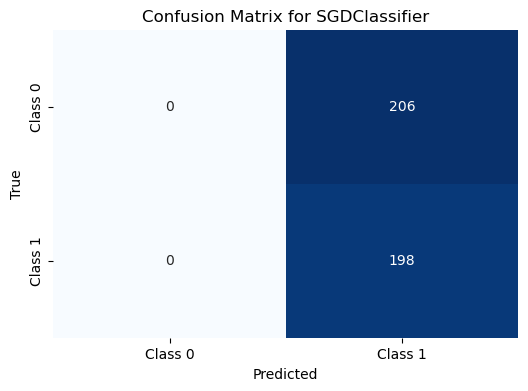

Perceptron()
	Training time: 0.178s
	Prediction time: 0.026s
	Accuracy: 0.490
	Precision: 0.490
	Recall: 1.000
	F1 Score: 0.658

Classification Report for Perceptron:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       206
           1       0.49      1.00      0.66       198

    accuracy                           0.49       404
   macro avg       0.25      0.50      0.33       404
weighted avg       0.24      0.49      0.32       404



C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


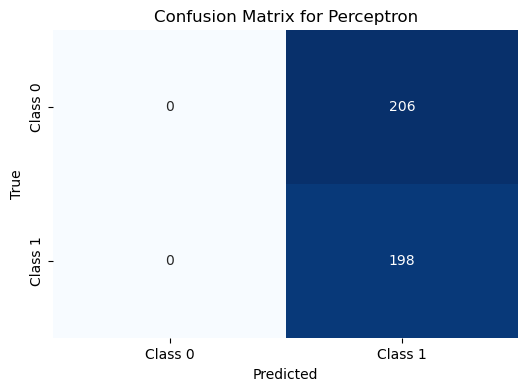

SVC(probability=True)
	Training time: 41.138s
	Prediction time: 4.552s
	Accuracy: 0.569
	Precision: 0.650
	Recall: 0.263
	F1 Score: 0.374
	ROC-AUC Score: 0.602

Classification Report for SVC:

              precision    recall  f1-score   support

           0       0.55      0.86      0.67       206
           1       0.65      0.26      0.37       198

    accuracy                           0.57       404
   macro avg       0.60      0.56      0.52       404
weighted avg       0.60      0.57      0.53       404



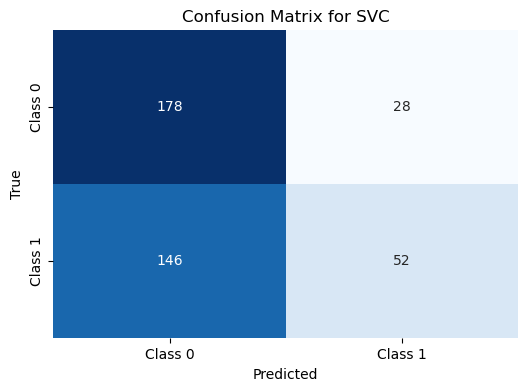

KNeighborsClassifier()
	Training time: 0.144s
	Prediction time: 4.335s
	Accuracy: 0.562
	Precision: 0.551
	Recall: 0.571
	F1 Score: 0.561
	ROC-AUC Score: 0.602

Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       206
           1       0.55      0.57      0.56       198

    accuracy                           0.56       404
   macro avg       0.56      0.56      0.56       404
weighted avg       0.56      0.56      0.56       404



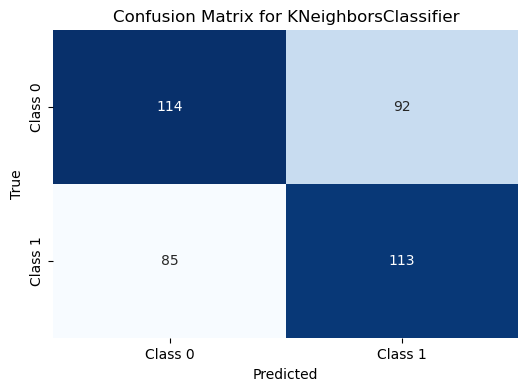

Model RadiusNeighborsClassifier() failed: No neighbors found for test samples array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 1

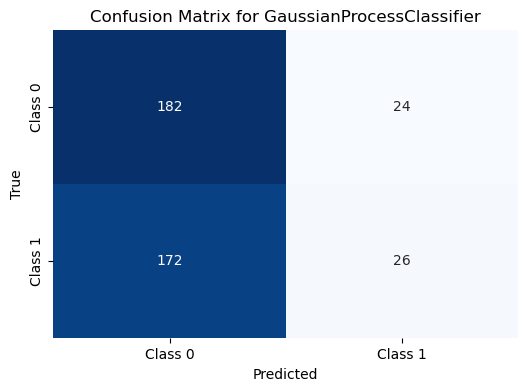

DecisionTreeClassifier()
	Training time: 0.324s
	Prediction time: 0.276s
	Accuracy: 0.720
	Precision: 0.716
	Recall: 0.712
	F1 Score: 0.714
	ROC-AUC Score: 0.722

Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       206
           1       0.72      0.71      0.71       198

    accuracy                           0.72       404
   macro avg       0.72      0.72      0.72       404
weighted avg       0.72      0.72      0.72       404



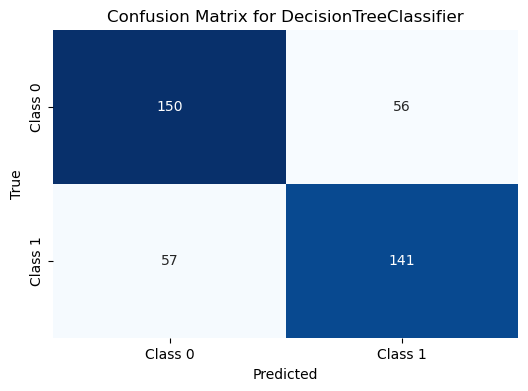

RandomForestClassifier()
	Training time: 5.106s
	Prediction time: 0.431s
	Accuracy: 0.797
	Precision: 0.799
	Recall: 0.783
	F1 Score: 0.791
	ROC-AUC Score: 0.866

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       206
           1       0.80      0.78      0.79       198

    accuracy                           0.80       404
   macro avg       0.80      0.80      0.80       404
weighted avg       0.80      0.80      0.80       404



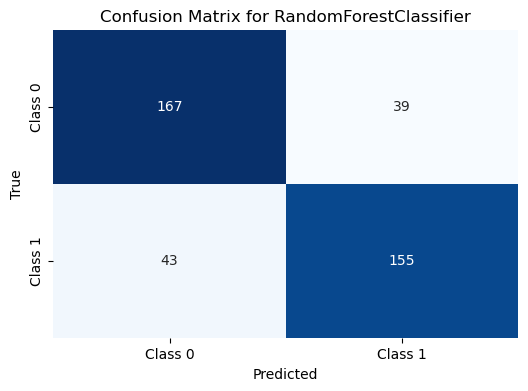

GradientBoostingClassifier()
	Training time: 7.619s
	Prediction time: 0.059s
	Accuracy: 0.748
	Precision: 0.740
	Recall: 0.747
	F1 Score: 0.744
	ROC-AUC Score: 0.841

Classification Report for GradientBoostingClassifier:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       206
           1       0.74      0.75      0.74       198

    accuracy                           0.75       404
   macro avg       0.75      0.75      0.75       404
weighted avg       0.75      0.75      0.75       404



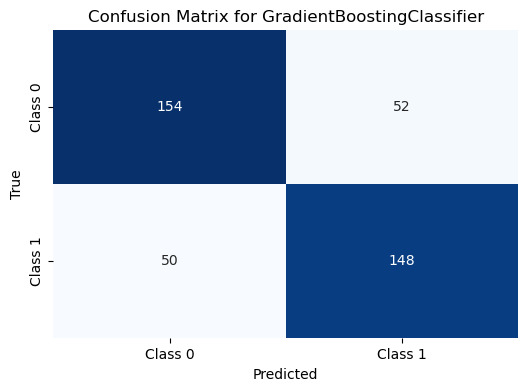

C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()
	Training time: 3.281s
	Prediction time: 0.661s
	Accuracy: 0.735
	Precision: 0.726
	Recall: 0.737
	F1 Score: 0.732
	ROC-AUC Score: 0.795

Classification Report for AdaBoostClassifier:

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       206
           1       0.73      0.74      0.73       198

    accuracy                           0.74       404
   macro avg       0.74      0.74      0.74       404
weighted avg       0.74      0.74      0.74       404



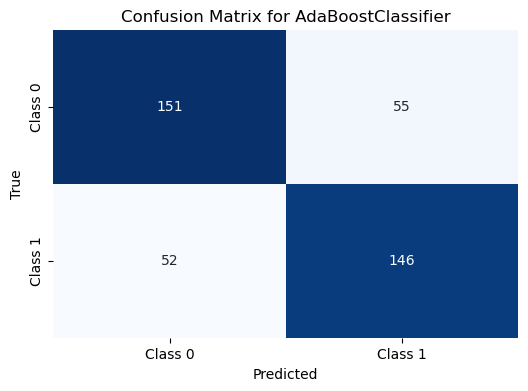

HistGradientBoostingClassifier()
	Training time: 34.157s
	Prediction time: 0.071s
	Accuracy: 0.787
	Precision: 0.783
	Recall: 0.783
	F1 Score: 0.783
	ROC-AUC Score: 0.848

Classification Report for HistGradientBoostingClassifier:

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       206
           1       0.78      0.78      0.78       198

    accuracy                           0.79       404
   macro avg       0.79      0.79      0.79       404
weighted avg       0.79      0.79      0.79       404



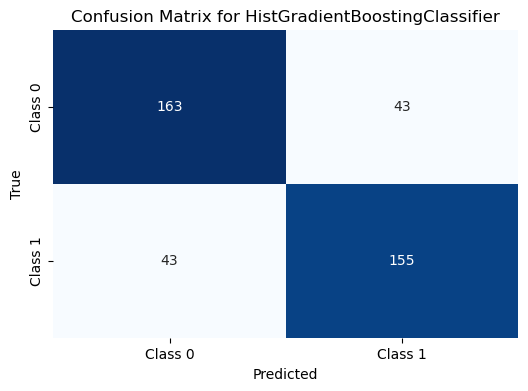

BaggingClassifier()
	Training time: 1.091s
	Prediction time: 0.236s
	Accuracy: 0.755
	Precision: 0.762
	Recall: 0.727
	F1 Score: 0.744
	ROC-AUC Score: 0.832

Classification Report for BaggingClassifier:

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       206
           1       0.76      0.73      0.74       198

    accuracy                           0.75       404
   macro avg       0.76      0.75      0.75       404
weighted avg       0.76      0.75      0.75       404



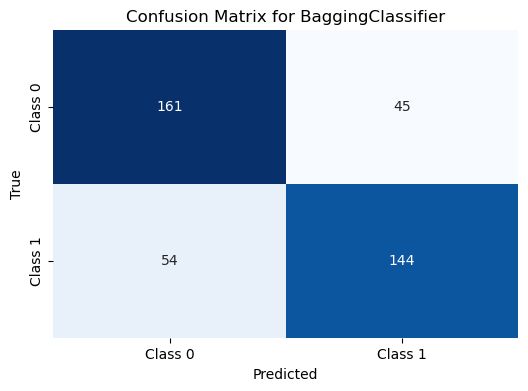

C:\Users\sudwa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# DataFrame to store ROC-AUC scores
results_df = pd.DataFrame(columns=['Model', 'ROC-AUC Score'])

# Iterate over models and evaluate performance
for model in classifiers:
    try:
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start

        start = time.time()
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        predict_time = time.time() - start

        # Collect performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None
        
        # Print performance metrics
        print(model)
        print(f"\tTraining time: {train_time:.3f}s")
        print(f"\tPrediction time: {predict_time:.3f}s")
        print(f"\tAccuracy: {accuracy:.3f}")
        print(f"\tPrecision: {precision:.3f}")
        print(f"\tRecall: {recall:.3f}")
        print(f"\tF1 Score: {f1:.3f}")
        if roc_auc is not None:
            print(f"\tROC-AUC Score: {roc_auc:.3f}")
        print()

        # Append the ROC-AUC score to the results dataframe (if available)
        if roc_auc is not None:
            row = pd.DataFrame({'Model': [type(model).__name__], 'ROC-AUC Score': [roc_auc]})
            results_df = pd.concat([results_df, row], ignore_index=True)

        # Classification report and confusion matrix
        print(f"Classification Report for {type(model).__name__}:\n")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.title(f'Confusion Matrix for {type(model).__name__}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    except Exception as e:
        print(f"Model {model} failed: {e}")
        print()

In [ ]:
# Sort the DataFrame by ROC-AUC score
results_df = results_df.sort_values(by='ROC-AUC Score', ascending=False)

# Display the sorted ROC-AUC scores
print(results_df)

# Plot a bar chart for ROC-AUC scores
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['ROC-AUC Score'], color='skyblue')
plt.xlabel('ROC-AUC Score')
plt.title('ROC-AUC Scores of Different Classifiers')
plt.gca().invert_yaxis()
plt.show()